In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from random import seed,sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("C:/Users/dilve/Downloads/Financial Fraud Dataset/PS_20174392719_1491204439457_log.csv")

# Summary

In [3]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.shape

(6362620, 11)

In [6]:
data.isnull().values.any()

False

No missing values

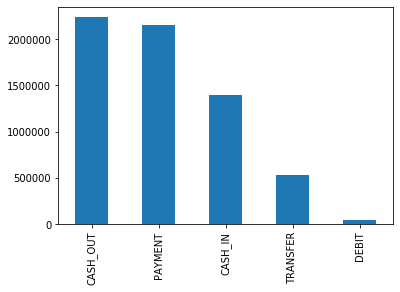

In [7]:
data['type'].value_counts().plot('bar')

The most commonly used transaction types are CASH-OUT, PAYMENT AND CASH-IN followed by TRANSFER. The DEBIT remains the least transaction system used by users.

In [8]:
# Subsetting data into observations with fraud and valid transactions:
fraud = data[data["isFraud"] == 1]

In [9]:
print("Fraud transactions by type: \n",fraud.type.value_counts())

Fraud transactions by type: 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


# #Looking balances before and after the transaction


In [10]:
wrong_orig_bal = sum(data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"])
wrong_dest_bal = sum(data["newbalanceDest"] + data["amount"] != data["newbalanceDest"])
print("Percentage of observations with balance errors in the account giving money: ", 100*round(wrong_orig_bal/len(data),2))
print("Percentage of observations with balance errors in the account receiving money: ", 100*round(wrong_dest_bal/len(data),2))

Percentage of observations with balance errors in the account giving money:  85.0
Percentage of observations with balance errors in the account receiving money:  100.0


# #Looking at Flagged Transactions

In [11]:
# how many observations were flagged as Fraud?
flagged = data[data["isFlaggedFraud"] == 1]
flagged_correctly = sum(flagged["isFraud"] == 1)
flagged_wrongly = len(flagged) - flagged_correctly
total = flagged_correctly + flagged_wrongly
print(flagged_correctly," observations were flagged correctly and ", flagged_wrongly, \
      " observations were flagged wrongly for a total of ", total, " flagged observations.")

# how many observations where the transaction is fraudulent, the transaction is a transfer and the amount is greater 
# than 200, 000 are in the dataset
should_be_flagged = fraud[(fraud["amount"] > 200000) & (fraud["type"] == "TRANSFER")]
print("no. of observations that should be flagged: ",len(should_be_flagged))

16  observations were flagged correctly and  0  observations were flagged wrongly for a total of  16  flagged observations.
no. of observations that should be flagged:  2740


# Looking at time 

Text(0.5, 1.0, '# of fraud transactions over time')

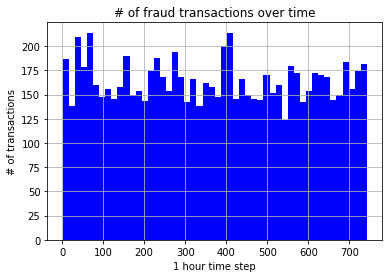

In [12]:
fraud.hist(column ="step",color="blue",bins=50)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")


The frequency at which fraudulent transactions occur does not seem to change much over time.

# MODEL BUILDING

In [13]:
# Creating a dummy variable for the variable 'type' and dropping the first one.
cont = pd.get_dummies(data['type'],prefix='type',drop_first=True)
#Adding the results to the master dataframe
data = pd.concat([data,cont],axis=1)

In [17]:
# Putting feature variable to X
X = data.drop(['isFraud','nameOrig','type','nameDest'],axis=1)

# Putting response variable to y
y = data['isFraud']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [19]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
1761278,161,75173.42,10607.00,0.00,32025.49,107198.91,0,1,0,0,0
592350,33,6928.79,0.00,0.00,0.00,0.00,0,0,0,1,0
5340707,374,7209.29,266576.17,273785.46,335407.97,328198.68,0,0,0,0,0
2034379,180,21567.77,176239.44,154671.67,0.00,0.00,0,0,0,1,0
3507961,259,10592.96,80606.00,70013.04,0.00,0.00,0,0,0,1,0


In [20]:
import statsmodels.api as sm
import seaborn as sns

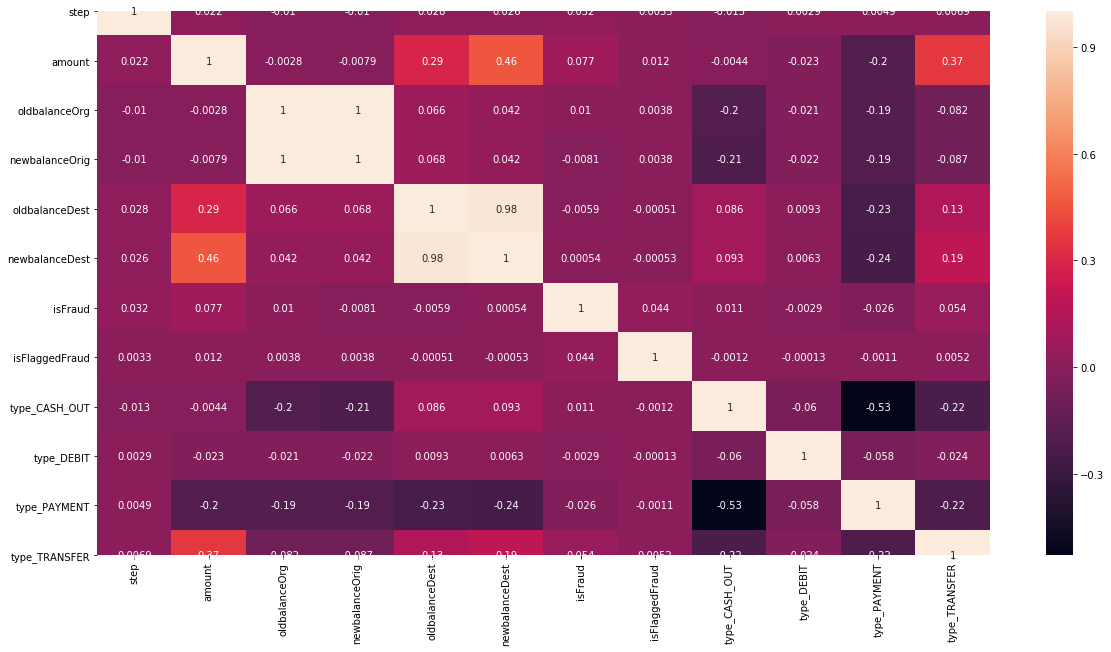

In [21]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(data.corr(),annot = True)

In [22]:

from sklearn.feature_selection import RFE
from sklearn import metrics
logsk = LogisticRegression()
rfe = RFE(logsk, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1]


In [23]:

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
lm_predict = logmodel.predict(X_test)

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(accuracy_score(lm_predict,y_test))
print(confusion_matrix(lm_predict,y_test))

0.9986991731917564
[[1906303    2478]
 [      5       0]]
